In [1]:
#import slm_utils
import pandas as pd
import config
import slm_utils
import figure_utils

import miscellaneous_utils as mu
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import os

color_mood = ["#a63a33","#f1c132","#3c414d","#d7d7de","#aaaaaa"]

font = {'family': 'sans-serif',
        'color':  'k',
        'size': 40,
        'weight':"bold"
        }
from statsmodels.tsa.stattools import adfuller

/tmp/ipykernel_24730/3188633231.py:12: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
/tmp/ipykernel_24730/3188633231.py:18: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
def calculate_BH(spcs):
    pi_df_BH = pd.read_csv("/u/home/r/rwolff/strain_stability_revisions/strainstability/analysis/pi/HMP/HMP/%s_pi.txt" % spcs,index_col=0)
    
    Fst = {}
    for ind1 in pi_df_BH.index:
        for ind2  in pi_df_BH.index:
            if ind1 != ind2:
                pi_w1 = pi_df_BH.loc[ind1,ind1]
                pi_w2 = pi_df_BH.loc[ind2,ind2]
            
                Fst[(ind1,ind2)] = 1 - np.mean([pi_w1,pi_w2])/pi_df_BH.loc[ind1,ind2]
            
    return Fst

In [3]:
def return_Fst(host,spc):
    dates = mu.return_dates(host)
    all_samples = mu.return_host_samples(host)
    pi_dir = "%s/pi/Poyet/%s" % (config.analysis_directory,host)
    pi_df = pd.read_csv("%s/%s_pi.txt" % (pi_dir,spc),index_col=0)
    pi_df_T = pd.DataFrame(columns=all_samples,index=all_samples)
    pi_df_T.loc[pi_df.index,pi_df.columns] = pi_df
    species_dates = dates.loc[pi_df.index].sort_values()
    first_date = species_dates.index[0]
    pi_df_BT = pi_df_T.loc[first_date]
    pi_df_W = pd.Series(np.diag(pi_df_T),index=pi_df_BT.index)
    
    Fst = pd.Series(dtype='float64' )
    for ind in pi_df_BT.index:
        Fst.loc[ind] = 1 - ((pi_df_W.loc[first_date] + pi_df_W.loc[ind])/2)/pi_df_BT.loc[ind]
        
    return Fst

In [4]:
H_all = {}
ts_all = {}
F_st_all = {}
for host in ["am","an","ae","ao"]:
    
    dates = mu.return_dates(host)
    
    pi_dir = "%s/pi/Poyet/%s" % (config.analysis_directory,host)

    good_species = [s[:-7] for s in os.listdir(pi_dir)]

    all_samples = dates.index
    Fst_df = pd.DataFrame(columns=all_samples,index=good_species)
    BH_df = pd.Series(dtype='float64' ,index=good_species)

    for species in good_species:
        Fst_df.loc[species] = return_Fst(host,species)
        BH_df.loc[species] = pd.Series(calculate_BH(species)).mean()
        print(species)
    
    Fst_prime = (Fst_df.T/BH_df).T
    
    H = {}
    ts = {}
    for s in Fst_prime.index:
        st = s
        y = Fst_prime.loc[s].dropna()
        H[st] = adfuller(y.values[1:])[1]
        ts[st] = (dates.loc[y.index].values,y.values)
    
    H_all[host] = H
    ts_all[host] = ts
    F_st_all[host] = Fst_prime

Phascolarctobacterium_sp_59817
Barnesiella_intestinihominis_62208
Faecalibacterium_prausnitzii_57453
Ruminococcus_bromii_62047
Bacteroides_uniformis_57318
Ruminococcus_bicirculans_59300
Bacteroides_xylanisolvens_57185
Eubacterium_rectale_56927
Bacteroides_ovatus_58035
Bacteroides_vulgatus_57955
Parabacteroides_merdae_56972
Bacteroides_stercoris_56735
Bacteroides_fragilis_54507
Ruminococcus_bromii_62047
Alistipes_putredinis_61533
Sutterella_wadsworthensis_56828
Paraprevotella_clara_33712
Bacteroides_clarus_62282
Bacteroides_ovatus_58035
Eubacterium_rectale_56927
Bacteroides_massiliensis_44749
Bacteroides_uniformis_57318
Bacteroides_vulgatus_57955
Bacteroides_xylanisolvens_57185
Barnesiella_intestinihominis_62208
Eubacterium_rectale_56927
Alistipes_putredinis_61533
Alistipes_onderdonkii_55464
Bacteroides_uniformis_57318
Bacteroides_massiliensis_44749
Bacteroides_vulgatus_57955
Bacteroides_thetaiotaomicron_56941
Bacteroides_ovatus_58035
Bacteroides_cellulosilyticus_58046
Bifidobacterium_a

In [5]:
for h in F_st_all.keys():
    F_st_all[h].index = [figure_utils.get_pretty_species_name(s) for s in F_st_all[h].index]
    F_st_all[h] = F_st_all[h][mu.return_dates(h).index]
    F_st_all[h].columns = mu.return_dates(h).values

In [6]:
f = 0
s = 0
for host in ["am","ao","an","ae"]:
    f+=(pd.Series(H_all[host]) > .05).sum()
    s+=pd.Series(H_all[host]).shape[0]
1 - (1.0*f)/s

0.7608695652173914

In [7]:
(s-f)/(1.0*s)

0.7608695652173914

In [ ]:
ts_all["am"]

In [ ]:
[s.var() for s in ts_all["am"]]

Text(0.475, 0.05, 'Time (days)')

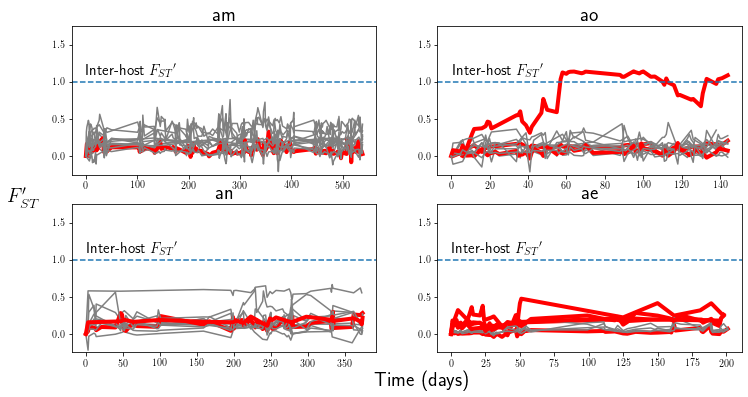

In [8]:
fig,axs = plt.subplots(2,2,figsize=(12,6))

axs = axs.ravel()

i = 0
for host in ["am","ao","an","ae"]:
    axs[i].set_title(host,size=20)
    for k in ts_all[host]:
        if H_all[host][k] > .05:
            axs[i].plot(ts_all[host][k][0],ts_all[host][k][1],color="red",lw=4)
        else:
            axs[i].plot(ts_all[host][k][0],ts_all[host][k][1],color="grey")

    axs[i].set_ylim([-.25,1.75])
    
    axs[i].axhline(1,ls="--")
    axs[i].text(1, 1.1, r"Inter-host ${F_{ST}}'$", fontsize = 15,color="k")

    i += 1

fig.text(0.05,.475,r"$F_{ST}'$",size=20)
fig.text(.475,.05,"Time (days)",size=20)

In [16]:
def plot_fst(ts_all,host,species=None,fst_fig=None):
    
    ts_plot = ts_all[host]
    dates = mu.return_dates(host)
    
    if fst_fig == None:
        fst_fig = plt.figure(constrained_layout=True,figsize=(24,6))
    
    gs = fst_fig.add_gridspec(1, 10)

    axs = fst_fig.add_subplot(gs[0, :-1])
    axs_null = fst_fig.add_subplot(gs[0, -1:])
 
    axs_null.axis('off')
    axs.set_xlim([-4,dates.iloc[-1] + 4])
    

    if species == None:
                
        for spc in ts_plot.keys():
            d,spc_frq = ts_plot[spc]
            
            axs.plot(d,spc_frq,label=figure_utils.get_pretty_species_name(spc),lw=4)
            axs.scatter(d,spc_frq,color="k",s=20,zorder=100)
            
        axs.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0),ncol=1, fancybox=True, shadow=True,prop={'size': 20,'style':'italic'})
        axs.set_xlabel("Time (days)",fontdict=font)
        axs.set_title(host,fontdict=font,fontstyle="italic",fontweight="bold")
        #axs.semilogy()
        #axs.text(1, .7, r"Inter-host ${F_{ST}}'$", fontsize = 25,color="red")
        
    if species != None:
        
        for spc in ts_plot.keys():
            d,spc_frq = ts_plot[spc]

            axs.plot(d,spc_frq,label=None,lw=1,color="grey",alpha=.5)
            axs.scatter(d,spc_frq,color="k",s=15,zorder=10,alpha=.5)
            
        
        #(Fst_plot.T).plot(ax=axs,label=None,color="grey",legend=None,lw=3,alpha=.7); 
        x,y =  ts_plot[species]
        axs.plot(x,y,color="#378293",label=figure_utils.get_pretty_species_name(species),zorder=10,lw=12.5);
        axs.set_xlabel("",fontdict=font)
        axs.scatter(x,y,color="k",s=40,zorder=100)
        axs.set_title(r"$\textit{%s}$" % figure_utils.get_pretty_species_name(species),size=60,fontstyle="italic",fontweight="bold")
        #axs.set_xticklabels([])
        #axs.set_ylim([.5*1e-1,max(1.9,1.2*(Fst_plot.loc[species].max()))])
        axs.text(1, 1.15, r"Inter-host $\boldsymbol{{F_{ST}}'}$", fontsize = 40,color="red")
        #axs.semilogy()
        
    #axs.scatter(dates.values,Fst_plot.loc[species].values,color="k",s=50,zorder=1000);
    
    #
    
    
    axs.axhline(1,color="red",lw=2)
    
    axs.set_ylabel(r"$\boldsymbol{{F_{ST}}'}$",fontdict=font)

    #axs.tick_params(axis='both', which='major', labelsize=15)
    #axs.tick_params(axis='both', which='major', labelsize=15)

    axs.spines['left'].set_linewidth(1)
    axs.spines['bottom'].set_linewidth(1)
    axs.spines['right'].set_linewidth(1)
    axs.spines['top'].set_linewidth(1)
  
    axs.tick_params('both', length=4, width=2, which='major',labelsize=25)
    axs.tick_params('both', length=2, width=2, which='minor')
    
    #axs.set_yticklabels(axs.get_yticks(), weight='bold')
    #axs.set_xticklabels(axs.get_xticks(), weight='bold')
    
    #axs.grid(True,alpha=1)
   
    

    #axs.set_xticks([])
    #axs.set_xticklabels([])
    #axs.tick_params(axis='y', which='major', labelsize=20,bottom="off")
     
    axs.set_ylim([-.25,1.5])
        
    return axs

<AxesSubplot:title={'center':'$\\textit{Bacteroides vulgatus}$'}, ylabel="$\\boldsymbol{{F_{ST}}'}$">

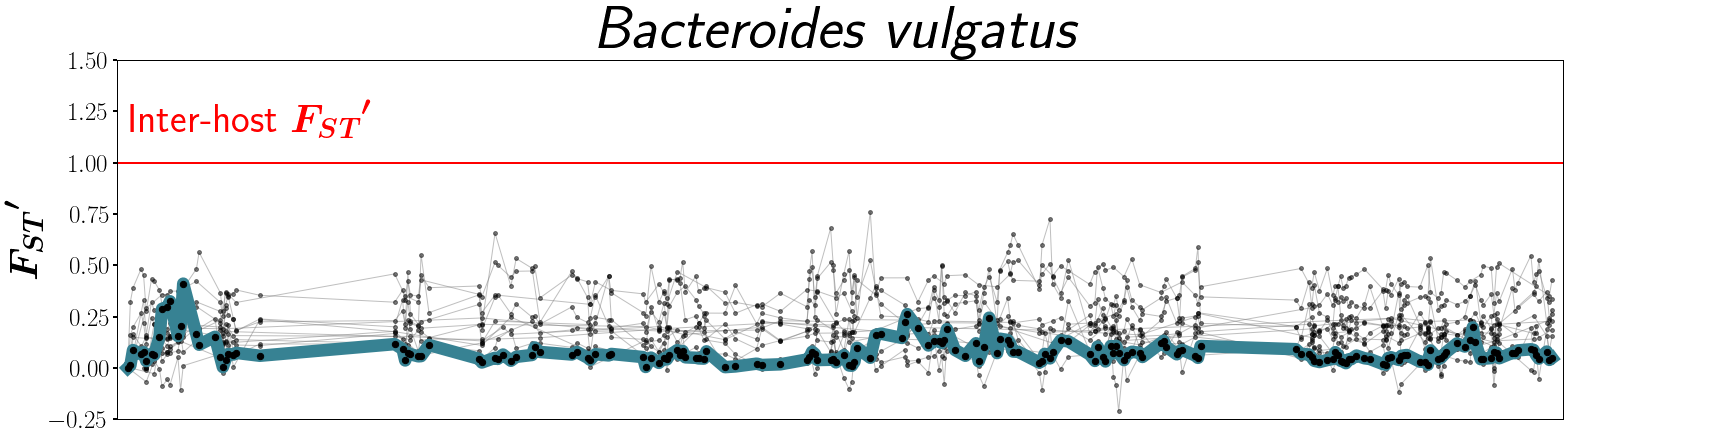

In [12]:
plot_fst(ts_all,"am",species="Bacteroides_vulgatus_57955")

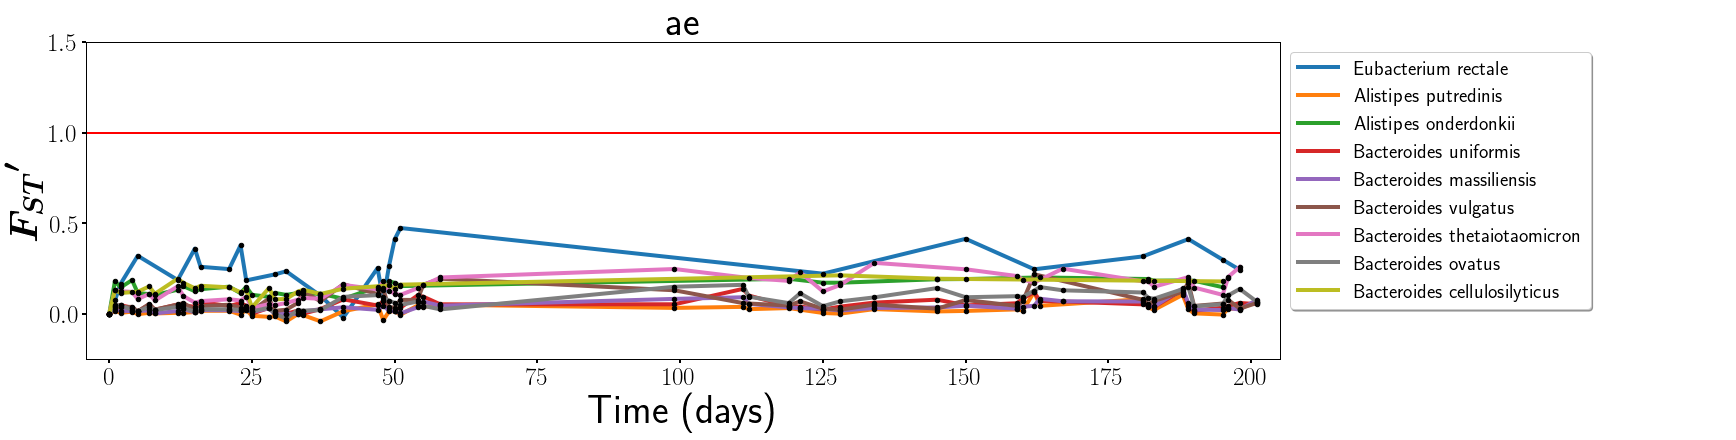

In [17]:
#am=plot_fst(ts_all,"am")
#an=plot_fst(ts_all,"an")
#ao=plot_fst(ts_all,"ao")
ae=plot_fst(ts_all,"ae")


In [3]:
def plot_snv_fig(chosen_strain,host,species,snv_fig=None):   
  
    if snv_fig == None:
        snv_fig = plt.figure(constrained_layout=True,figsize=(16,12))
    
    gs = snv_fig.add_gridspec(1, 10)

    axs= snv_fig.add_subplot(gs[0, :-1])
    axs_null = snv_fig.add_subplot(gs[0, -1:])
 
    axs_null.axis('off')
    
    #axs.set_ylabel(r"$\text{SNV frequency}$",fontdict=font,labelpad=25) 
    axs.spines['left'].set_linewidth(1)
    axs.spines['bottom'].set_linewidth(1)
    axs.spines['right'].set_linewidth(1)
    axs.spines['top'].set_linewidth(1)
  
    axs.tick_params('both', length=3, width=2, which='major',labelsize=20)
    axs.tick_params('both', length=3, width=2, which='minor')
    #axs.grid(True,alpha=1)    

    axs.set_xticklabels([])
    #axs.tick_params(axis='both', which='major', labelsize=15)

    analysis_dir = config.analysis_directory
    cluster_dir = "%s/clusters/Poyet/%s/%s" % (analysis_dir,host,species)
    strain_snv_dic = {}
    strain_centroid_dic = {}
    
    i = 1
    for strain in os.listdir(cluster_dir):

        df = pd.read_csv("%s/%s" % (cluster_dir,strain),index_col=0)
        strain_snv_dic[i] = df
        strain_centroid_dic[i] = df.median()

        i+=1

    if len(strain_centroid_dic) == 1:
        strain_snv_dic[2] = 1 - strain_snv_dic[1]
        strain_centroid_dic[2] = 1 - strain_centroid_dic[1]
    
    #else:
    #    strain_snv_dic[3] = 1 - strain_snv_dic[3]
    #    strain_centroid_dic[3] = 1 - strain_centroid_dic[3]

    letter_list = ["A","B","C"]

    dates = mu.return_dates(host)
    
    dates = dates.loc[strain_snv_dic[1].columns].sort_values()

    axs.set_xlim([-4,dates.iloc[-1] + 4])
    
    strain_lines = []

    i = 0
    for strain in strain_centroid_dic:

        
        if letter_list[i] == chosen_strain:
            xx = 5000
            yy = .01
            lww = 2
            C = strain_snv_dic[strain].sample(min(strain_snv_dic[strain].shape[0],xx)).T.values
            axs.plot(dates.values,strain_centroid_dic[strain],color="k",label=letter_list[i],lw=4,alpha=.75,zorder=10);
            axs.plot(dates.values,C,lw=lww,color="#378293",alpha=yy);
            strain_line = Line2D([0], [0], label=letter_list[i], color=color_mood[i])
            strain_lines.append(strain_line)
            
        else:
            xx = 2500
            yy = .01
            lww = 2
            C = strain_snv_dic[strain].sample(min(strain_snv_dic[strain].shape[0],xx)).T.values
            axs.plot(dates.values,C,lw=lww,color="grey",alpha=yy);
            axs.plot(dates.values,strain_centroid_dic[strain],color="k",label=letter_list[i],lw=2,alpha=.75,zorder=10);
            strain_line = Line2D([0], [0], label=letter_list[i], color=color_mood[i])
            strain_lines.append(strain_line)
            
        #C = strain_snv_dic[strain].sample(min(strain_snv_dic[strain].shape[0],xx)).T.values

        #axs.plot(dates.loc[species_samples[25:45]].values,C[25:45],lw=1.5,color=color_mood[i],alpha=50*yy);

        i+=1
        
    axs.set_xticks([])
    plt.subplots_adjust(wspace=0.01, hspace=0);

In [4]:
def plot_slm_fig(host,species,fig3=None):
    
    df = pd.read_csv("strains_%s.csv" % host,index_col=0) 
    dates = mu.return_dates(host)
    obs_data = df.loc[species]
    obs_data = obs_data[obs_data.notna()]

    dates = dates.loc[obs_data.index].sort_values()

    obs_data = obs_data.loc[dates.index]
    
    train_num = len(obs_data)//3

    params = slm_utils.fit_SLM_params(obs_data,n=train_num)

    ## initialize SLM 
    S = slm_utils.slm(sigma=params["sigma"],K=params["K"],tau=1,delta_t=1.0/1000)
    S.run_sim(num_iters=int(dates.iloc[-1]/S.delta_t),num_reps=500,record_steps=True);
    
    if fig3 == None:
        fig3 = plt.figure(constrained_layout=True,figsize=(16,12))
        
    gs = fig3.add_gridspec(1, 10)

    f3_ax1 = fig3.add_subplot(gs[0, :-1])
    f3_ax1_H = fig3.add_subplot(gs[0, -1:])

    f3_ax1.semilogy()
    f3_ax1_H.semilogy();

    #f3_ax1.grid(True,alpha=1)
    f3_ax1.set_xlabel(r"$\textbf{Time (days)}$",fontdict=font)
    f3_ax1.plot(dates.values,obs_data.values,"-",color="#378293",lw=6,zorder=100)
    f3_ax1.scatter(dates.values,obs_data.values,s=40,color="k",edgecolor="k",linewidths=1,zorder=101)

    #f3_ax1.axhline(upper_bound ,color="k",lw=.25)
    #f3_ax1.axhline(lower_bound,color="k",lw=.25)

    f3_ax1.set_xlim([-4,dates.iloc[-1] + 4])

    #ax.fill_between(lower_bound,upper_bound,color="green",alpha=.05)

    #ax.set_ylim([.02,.5])

    sim_data = np.array(S.trajectory)[[int(d/S.delta_t) for d in dates.values]]
    
    plot_min = min(min(obs_data),min([min(s) for s in sim_data]))*.75
    plot_max = max(max(obs_data),max([max(s) for s in sim_data]))*1.5
    plot_max = max(1.1,plot_max)
    
    #f3_ax1.set_ylabel("Strain abundance",fontdict=font,labelpad=25)
    f3_ax1.plot(dates.values,sim_data,color="red",alpha=.05);

    f3_ax1_H.tick_params(labelleft=False, labelbottom=False)

    f3_ax1_H.set_xticks([])
    f3_ax1_H.set_yticks([])

    f3_ax1.spines['right'].set_linewidth(1)
    f3_ax1_H.spines['left'].set_linewidth(1)
    #f3_ax1_H.spines["right"].set_linewidth(.5)
    #f3_ax1_H.spines["bottom"].set_linewidth(.5)
    #f3_ax1_H.spines["top"].set_linewidth(.5)
    
    f3_ax1.tick_params(axis='x', which='major',length=4, width=3, labelsize=25)
    f3_ax1.tick_params('y', length=4, width=2, which='major',labelsize=25)
    f3_ax1.tick_params('y', length=2, width=2, which='minor')

    f3_ax1.spines['right'].set_linewidth(1)
    f3_ax1.spines['top'].set_linewidth(1)
    f3_ax1.spines['bottom'].set_linewidth(1)
    f3_ax1.spines['left'].set_linewidth(1)

    f3_ax1_H.hist(obs_data, bins=np.logspace(np.log(plot_min),np.log(plot_max),50), density=True, color="#378293", orientation='horizontal')

    f3_ax1.set_ylim([plot_min,plot_max])
    f3_ax1_H.set_ylim([plot_min,plot_max])

    xx = np.logspace(np.log(plot_min),np.log(plot_max),100000)
    f3_ax1_H.plot(S.afd.pdf(xx),xx,color="red",alpha=.5)
    f3_ax1_H.fill_betweenx(xx,S.afd.pdf(xx),color="red",alpha=.3)
    f3_ax1_H.axis('off')

    plt.subplots_adjust(wspace=0.01, hspace=0);

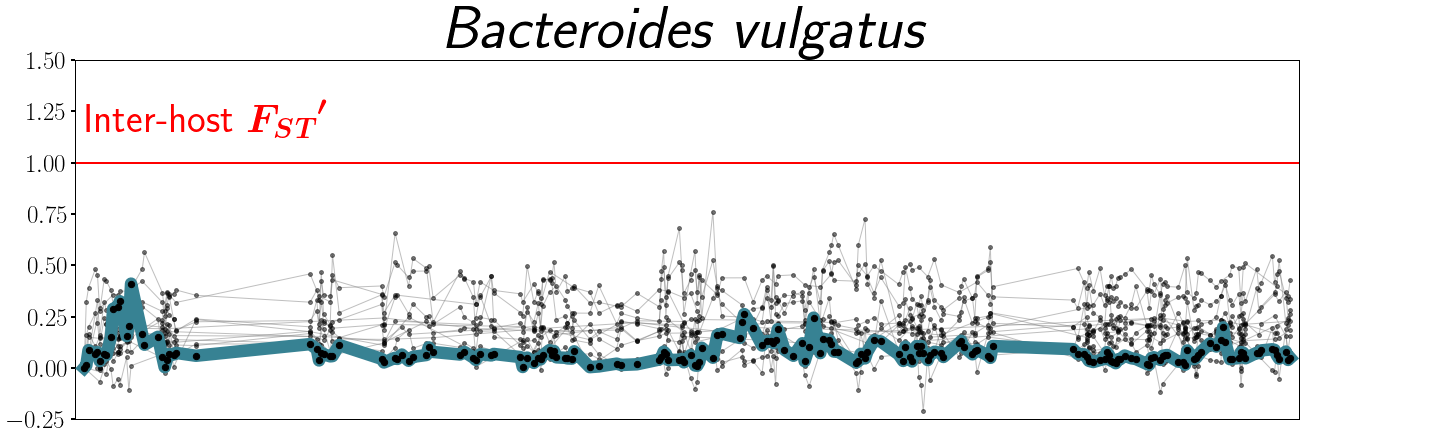

In [67]:
fig = plt.figure(constrained_layout=True,figsize=(20,6))

ao=plot_fst(ts_all,"am",fst_fig=fig,species = "Bacteroides_vulgatus_57955")

/tmp/ipykernel_7628/472001558.py:89: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.01, hspace=0);


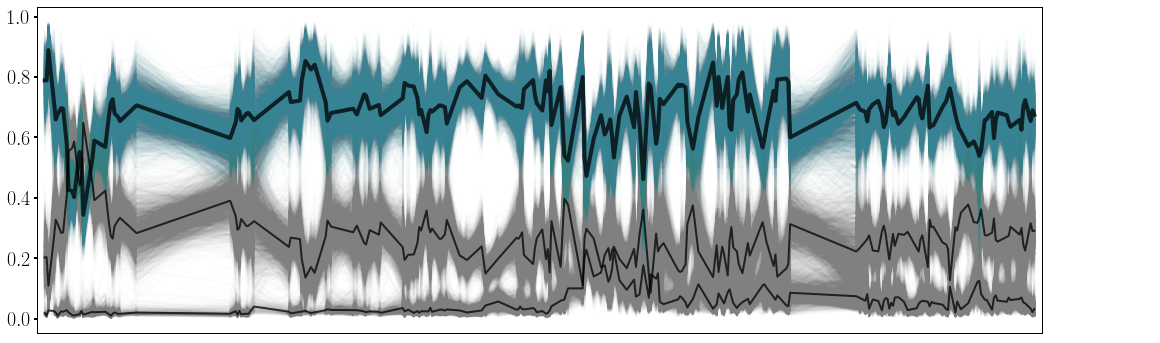

In [9]:
fig = plt.figure(constrained_layout=True,figsize=(20,6))

plot_snv_fig("B","am","Bacteroides_vulgatus_57955",snv_fig=fig)

/tmp/ipykernel_7628/3807380754.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.01, hspace=0);


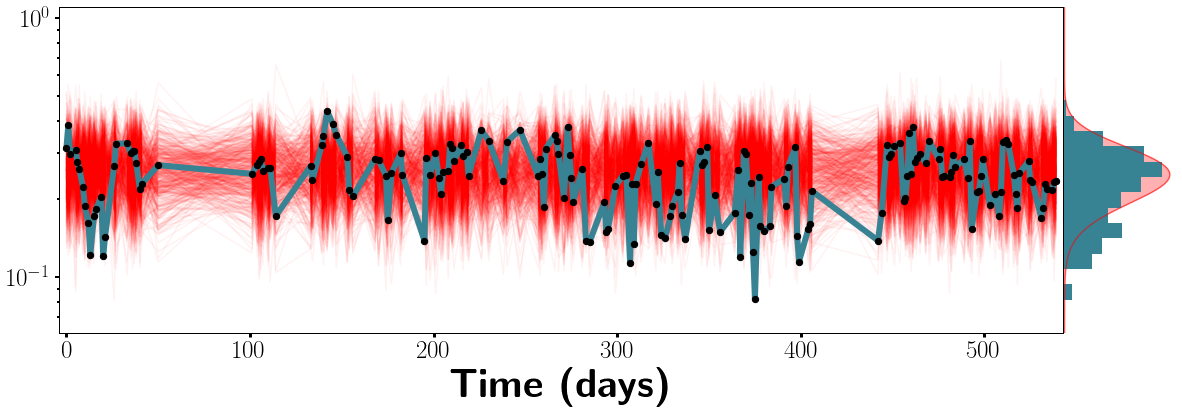

In [10]:
fig = plt.figure(constrained_layout=True,figsize=(20,6))
plot_slm_fig("am","Bacteroides_vulgatus_57955_B",fig3=fig)

In [5]:
def plot_pi(host,pi_fig=None):

    if pi_fig == None:
        pi_fig = plt.figure(constrained_layout=True,figsize=(16,12))
    
    gs = pi_fig.add_gridspec(1, 10)

    axs= pi_fig.add_subplot(gs[0, :-1])
    axs_null = pi_fig.add_subplot(gs[0, -1:])
 
    axs_null.axis('off')
    
    pi_dir = "%s/pi/Poyet/%s" % (config.analysis_directory,host)
    
    dates = mu.return_dates(host)
    
    pi_df = pd.read_csv("%s/%s_pi.txt" % (pi_dir,species),index_col=0)

    pi_df_W = pd.Series(np.diag(pi_df),index=pi_df.index)
    
    dates = dates.loc[pi_df_W.index].sort_values()
    
    pi_df_W = pi_df_W.loc[dates.index]
    
    axs.set_ylabel(r"$\pi$",size=20,labelpad=50) 
    axs.spines['right'].set_linewidth(3)
    axs.spines['top'].set_linewidth(3)
    axs.spines['bottom'].set_linewidth(3)
    axs.spines['left'].set_linewidth(3)
    axs.grid(True,alpha=1)    
    

    axs.set_xlim([-4,dates.iloc[-1] + 4])
    
    #axs.semilogy()
    
    axs.plot(dates.values,pi_df_W,"o-");
    

In [8]:
def plot_pi(host,species=None,pi_fig=None):
    
    if pi_fig == None:
        pi_fig = plt.figure(constrained_layout=True,figsize=(24,6))
    
    gs = pi_fig.add_gridspec(1, 10)

    axs = pi_fig.add_subplot(gs[0, :-1])
    axs.set_title(host, size=30,fontstyle="italic")
    
    axs_null = pi_fig.add_subplot(gs[0, -1:])
 
    axs_null.axis('off')
    
    pi_dir = "%s/pi/Poyet/%s" % (config.analysis_directory,host)
    
    good_species = [s[:-7] for s in os.listdir(pi_dir)]
    dates = mu.return_dates(host)

    axs.set_xlim([-4,dates.iloc[-1] + 4])

    all_samples = mu.return_host_samples(host)
    
    pi_df_W = pd.DataFrame(columns=all_samples,index=good_species)

    for spc in good_species:
        pi_df = pd.read_csv("%s/%s_pi.txt" % (pi_dir,spc),index_col=0)
        pi_df_T = pd.DataFrame(columns=all_samples,index=all_samples)
        pi_df_T.loc[pi_df.index,pi_df.columns] = pi_df
        species_dates = dates.loc[pi_df.index].sort_values()
        first_date = species_dates.index[0]
        pi_df_W.loc[spc] = np.diag(pi_df_T)
 
    pi_df_W = pi_df_W.loc[:,[d for d in dates.index if d in pi_df_W.columns]]
    

    species_samples = pi_df_W.columns
    
    pi_df_W.columns = dates.loc[species_samples]
    
    for spc in pi_df_W.index:
        spc_frq = pi_df_W.loc[spc]
        spc_frq = spc_frq[spc_frq.notna()]
        d = spc_frq.index
        axs.scatter(d,spc_frq.values,color="k",s=20,zorder=100)
   
    pi_df_W.index = [figure_utils.get_pretty_species_name(w) for w in pi_df_W.index]
    pi_df_W.T.fillna(method="backfill").plot(ax=axs,lw=4)
    #axs.scatter(dates.values,Fst_plot.loc[species].values,color="k",s=50,zorder=1000);
        
    axs.semilogy()
    
   # axs.axhline(1,color="k",lw=2)
    #axs.set_ylabel("Population similarity" + "\n" + r"$(1 - F_{ST})$",size=20,labelpad=30)
    
    axs.spines['left'].set_linewidth(3)
    axs.spines['bottom'].set_linewidth(3)
    axs.spines['right'].set_linewidth(3)
    axs.spines['top'].set_linewidth(3)

    axs.tick_params('both', length=7, width=2, which='major',labelsize=20)
    axs.tick_params('both', length=3, width=2, which='minor')
       
    #axs.grid(True,alpha=1)
    axs.set_xlabel("Time (days)",size=30)
    
    axs.tick_params(axis='y', which='major', labelsize=20,bottom="off")
    
    axs.set_ylabel(r"$\pi$",size=30)
    axs.set_title(host,size=30,fontstyle="italic",fontweight="bold")
    axs.set_ylim([1e-4,1e-2])
    axs.legend(loc='upper left', bbox_to_anchor=(1.0, 1.08),
               ncol=1, fancybox=True, shadow=True,prop={'size': 20,'style':'italic'})
#axs.set_ylim([.05,3])

In [9]:
def return_pi(host):
    
    pi_dir = "%s/pi/Poyet/%s" % (config.analysis_directory,host)
    
    good_species = [s[:-7] for s in os.listdir(pi_dir)]
    dates = mu.return_dates(host)

    all_samples = mu.return_host_samples(host)
    
    pi_df_W = pd.DataFrame(columns=all_samples,index=good_species)

    for spc in good_species:
        pi_df = pd.read_csv("%s/%s_pi.txt" % (pi_dir,spc),index_col=0)
        pi_df_T = pd.DataFrame(columns=all_samples,index=all_samples)
        pi_df_T.loc[pi_df.index,pi_df.columns] = pi_df
        species_dates = dates.loc[pi_df.index].sort_values()
        first_date = species_dates.index[0]
        pi_df_W.loc[spc] = np.diag(pi_df_T)
 
    pi_df_W = pi_df_W.loc[:,[d for d in dates.index if d in pi_df_W.columns]]
    

    return(pi_df_W)

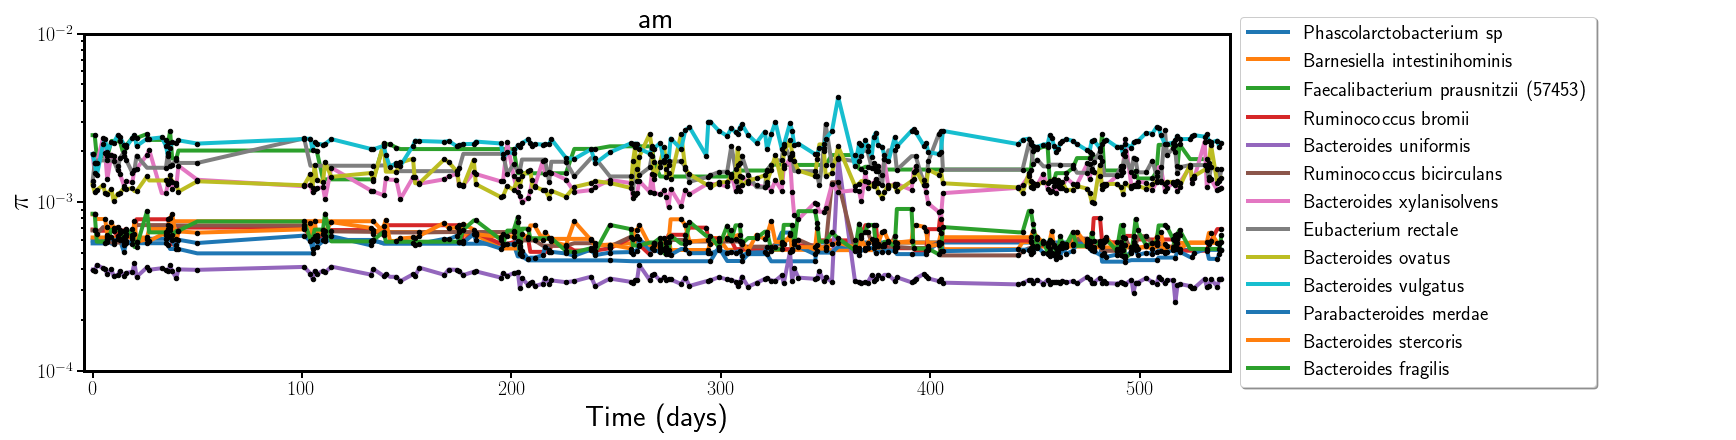

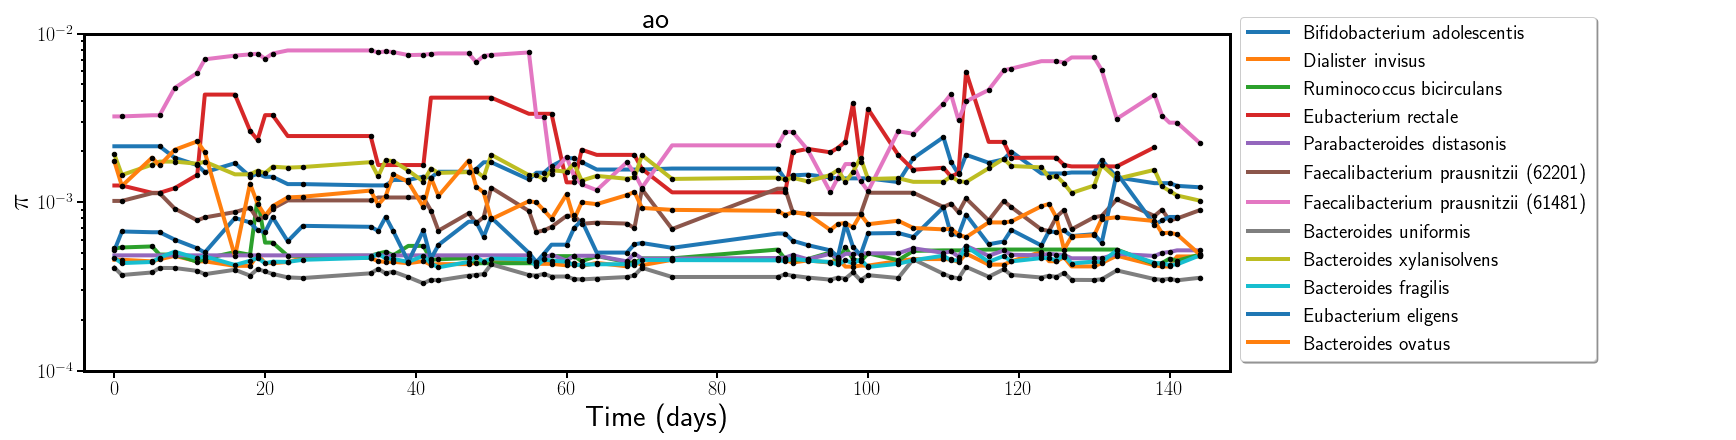

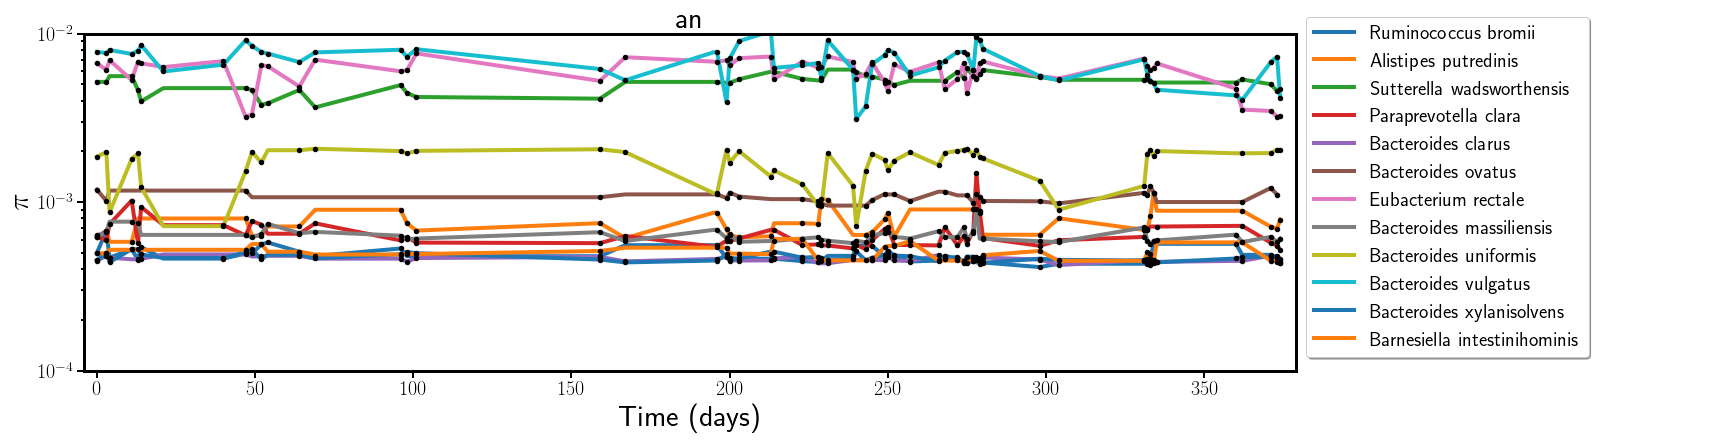

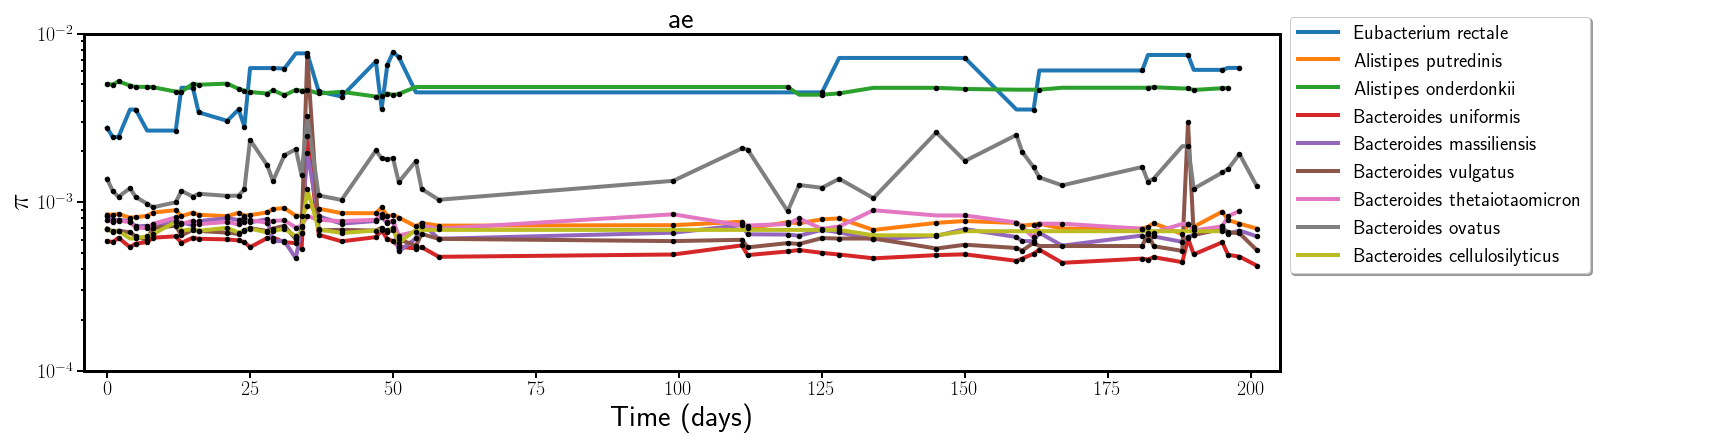

In [10]:
plot_pi("am");
plot_pi("ao");
plot_pi("an");
plot_pi("ae");